In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import accuracy_score,log_loss,precision_score,f1_score

from mlfinlab.cross_validation.cross_validation import ml_get_train_times,ml_cross_val_score,PurgedKFold
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                                    single_feature_importance, plot_feature_importance)
from mlfinlab.feature_importance.orthogonal import (feature_pca_analysis, get_pca_rank_weighted_kendall_tau,
                                                    get_orthogonal_features,_standardize_df,_get_eigen_vector)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score

from mlfinlab.backtest_statistics.statistics import (timing_of_flattening_and_flips, average_holding_period,
                                                     bets_concentration, all_bets_concentration,
                                                     drawdown_and_time_under_water, sharpe_ratio,
                                                     information_ratio, probabilistic_sharpe_ratio,
                                                     deflated_sharpe_ratio, minimum_track_record_length)
from mlfinlab.cross_validation.combinatorial import CombinatorialPurgedKFold


import warnings
warnings.filterwarnings("ignore")

In [3]:
def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000):
    # generate a random dataset for a classification problem
    #From: Advances in Financial Machine Learning 

    from sklearn.datasets import make_classification
    trnsX,cont=make_classification(n_samples=n_samples,
                                   n_features=n_features,
                                   n_informative=n_informative,
                                   n_redundant=n_redundant,
                                   random_state=0,
                                   shuffle=False)
    df0=pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(), end=pd.datetime.today())
    trnsX,cont=pd.DataFrame(trnsX,index=df0), pd.Series(cont,index=df0).to_frame('bin')
    df0=['I_'+str(i) for i in range(n_informative)] + ['R_'+str(i) for i in range(n_redundant)]
    df0+=['N_'+str(i) for i in range(n_features-len(df0))]
    trnsX.columns=df0
    cont['w']=1./cont.shape[0]
    cont['t1']=pd.Series(cont.index,index=cont.index)
    return trnsX,cont

# Feature analysis

1) Generate synthetic Matrix (X,y) and peforme feature analysis: MDI, MDA and SFI

2) Mean Decrease Impurity (MDI) - In sample sample exclusive for tree-based classifiers

"At each node of each decision tree, the selected feature splits the subset it received in such a way that impurity is" [1]

3) Mean Decrease Accuracy (MDA) - Out of sample 

"Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS)method." [1]

4) Single Feature Analysis (SFI)

"Single feature importance (SFI) is a cross-section predictive-importance (out-of- sample) method. It computes the OOS performance score of each feature in isolation." [1]

[1] - Advances in Financial Machine Learning -Chapter 8

In [4]:
_,cont=getTestData(5,3,2,10)


I - Informative features

R - Redundant features

N - Non-informative features (noise)

Y = Y(I,R)

In [5]:
size = 200
np.random.seed(seed=10)
X_seed = np.random.normal(0, 1, size)
sig=0.4
I0 = X_seed + np.random.normal(0, sig, size)
I1 = X_seed + np.random.normal(0, sig, size)
I2 = X_seed + np.random.normal(0, sig, size)
R0 = X_seed + np.random.normal(0, sig, size)
R1 = 1.5*R0
R2 = R1
N0 =        + np.random.normal(0, sig, size)
N1 =        + np.random.normal(0, sig, size)
N2 =        + np.random.normal(0, sig, size)
N3 =        + np.random.normal(0, sig, size)

Y = I0 + I1 + I2 + R0 + R1 + R2
data=pd.DataFrame({'Y':Y})
data['I_0']=I0
data['I_1']=I1
data['I_2']=I2
data['R_0']=R0
data['R_1']=R1
data['R_2']=R2
data['N_0']=N0
data['N_1']=N1
data['N_2']=N2
data['N_3']=N3

#print (data)
yft=data.columns.values[0]
xft=data.columns.values[1:]

In [14]:
xdata=data[xft]
ydata=np.sign(data[yft])

n_estimator=1000
rf=DecisionTreeClassifier(criterion='entropy',max_features=1,#None,
                          class_weight='balanced',min_weight_fraction_leaf=0.0)


rf=BaggingClassifier(base_estimator=rf,n_estimators=n_estimator,max_features=1.,#max_samples=max_samples,
                     oob_score=True)


rf.fit(xdata,ydata)
print ('Random Forest fitted')

t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
cv_gen=PurgedKFold(10,t1.t1)

Random Forest fitted


### MDI

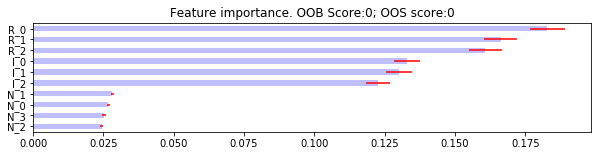

minimum importance: 0.1


In [15]:
imp = mean_decrease_impurity(rf,xft)
plot_feature_importance(imp,0,0)
print ('minimum importance:',1/len(xft))

### MDA

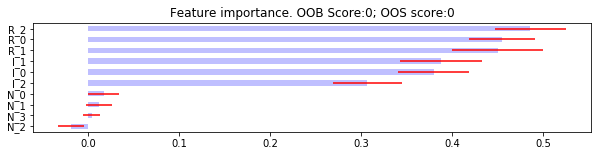

In [16]:
mda=mean_decrease_accuracy(rf,xdata,ydata,cv_gen,scoring=log_loss)

plot_feature_importance(mda,0,0)


### SFI

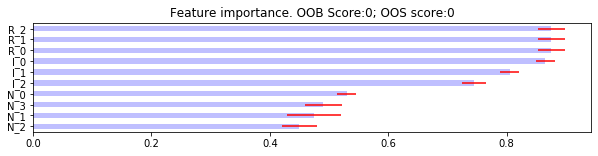

In [25]:
sfi=single_feature_importance(rf,xdata,ydata,cv_gen,scoring=accuracy_score)

plot_feature_importance(sfi,0,0)


# PCA analysis

In [20]:
X=data[xft].copy()
Z=X.sub(X.mean(), axis=1).div(X.std(), axis=1)
ZtZ=pd.DataFrame(np.dot(Z.T,Z),index=X.columns,columns=X.columns)
eVal,eVec=np.linalg.eigh(ZtZ)
idx=eVal.argsort()[::-1]
eVal=eVal[idx]
#eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
th=0.999
eVal,eVec=_get_eigen_vector(ZtZ, th)

Xdot = pd.DataFrame(get_orthogonal_features(X,th), index=X.index).add_prefix("PCA_")
Xdot.head()
#eVal=eVal.reset_index()#index=Xdot.index)
#eVal=eVal.reindex(Xdot.columns)
eVal=pd.Series(eVal.values,index=Xdot.columns)

print ('Eigen values:\n')
print (eVal)
print (Xdot.head())

Eigen values:

PCA_0    1094.587941
PCA_1     242.920648
PCA_2     198.054522
PCA_3     180.754070
PCA_4     173.942822
PCA_5      49.859616
PCA_6      29.263338
PCA_7      20.617042
dtype: float64
      PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0  3.299290  0.759680  1.452347 -0.540760  1.474209  0.126774 -0.130131   
1  1.553449 -0.309398  0.437784 -0.822939  0.529945 -0.230467  0.308447   
2 -3.356231 -1.150411  1.170876 -0.547521  1.308322 -0.855631 -0.254309   
3 -0.009526  1.584539  0.865854 -0.313115  0.433659 -0.030279  0.242042   
4  1.625890  0.492901  0.575790  1.332189 -0.024888 -0.810630 -0.511538   

      PCA_7  
0 -0.095705  
1  0.638620  
2 -0.238369  
3 -0.177706  
4  0.181503  


In [21]:
RANDOM_STATE=100
n_estimator=1000
maxsamples=1
rf=DecisionTreeClassifier(criterion='entropy',
                          max_features=1,#None,#1,
                          class_weight='balanced',
                          min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,
                     n_estimators=n_estimator,
                     max_features=1.,
                     #max_samples=maxsamples,
                     oob_score=True)

Y=np.sign(data[yft])
Xpca=Xdot.copy()

base = datetime.today()
numdays=len(Xpca)
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
w=[1/len(cont) for x in range(numdays)]
w=pd.DataFrame({'w':w})
w=w.set_index(w.w)

rf.fit(Xpca,Y)
cv_gen=PurgedKFold(10,t1.t1)

### PCA MDI

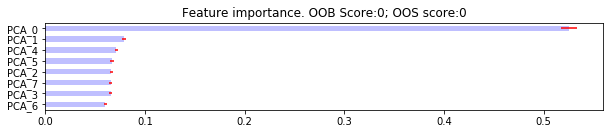

minimum importance: 0.1


{'Pearson': (0.04709331611667207, 0.7117354772171212),
 'Spearman': SpearmanrResult(correlation=0.06607802824841759, pvalue=0.6039190335863593),
 'Kendall': KendalltauResult(correlation=0.05261211169542764, pvalue=0.5588757555981987),
 'Weighted_Kendall_Rank': WeightedTauResult(correlation=0.35948939365496535, pvalue=nan)}

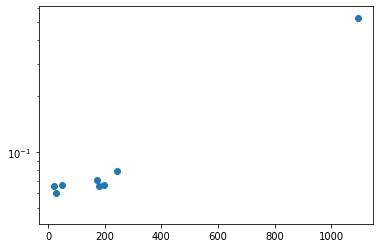

In [22]:
import matplotlib.pyplot as plt
imp = mean_decrease_impurity(rf,Xpca.columns)
plot_feature_importance(imp,0,0)
print ('minimum importance:',1/len(xft))
fig,aux=plt.subplots()
aux.scatter(eVal.loc[imp.index],imp['mean'])
aux.set_yscale('log')
feature_pca_analysis(Xpca,imp)

### PCA MDA

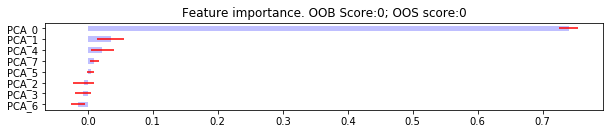

In [23]:
#MDA
imp=mean_decrease_accuracy(rf,Xpca,Y,cv_gen,scoring=log_loss)
plot_feature_importance(imp,0,0)


### PCA SFI

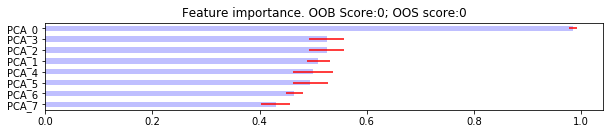

In [26]:
#SFI
imp=single_feature_importance(rf,Xpca,Y,cv_gen,scoring=accuracy_score)
plot_feature_importance(imp,0,0)
